# Lambda School Data Science Unit 4 Sprint Challenge 4

## RNNs, CNNs, AutoML, and more...

In this sprint challenge, you'll explore some of the cutting edge of Data Science.

*Caution* - these approaches can be pretty heavy computationally. All problems were designed so that you should be able to achieve results within at most 5-10 minutes of runtime on Colab or a comparable environment. If something is running longer, doublecheck your approach!

## Part 1 - RNNs

Use an RNN to fit a simple classification model on tweets to distinguish from tweets from Austen Allred and tweets from Weird Al Yankovic.

Following is code to scrape the needed data (no API auth needed, uses [twitterscraper](https://github.com/taspinar/twitterscraper)):

In [1]:
!pip install twitterscraper

  Stored in directory: C:\Users\edwar\AppData\Local\pip\Cache\wheels\45\50\9b\70128bca07e2bf8b5ed3f504002e9e74a6eaa5e756341b6931
  Stored in directory: C:\Users\edwar\AppData\Local\pip\Cache\wheels\a0\b0\b2\4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built twitterscraper bs4


In [2]:
from twitterscraper import query_tweets

austen_tweets = query_tweets('from:austen', 1000)
len(austen_tweets)

INFO: queries: ['from:austen since:2006-03-21 until:2006-11-14', 'from:austen since:2006-11-14 until:2007-07-11', 'from:austen since:2007-07-11 until:2008-03-05', 'from:austen since:2008-03-05 until:2008-10-30', 'from:austen since:2008-10-30 until:2009-06-25', 'from:austen since:2009-06-25 until:2010-02-19', 'from:austen since:2010-02-19 until:2010-10-15', 'from:austen since:2010-10-15 until:2011-06-11', 'from:austen since:2011-06-11 until:2012-02-04', 'from:austen since:2012-02-04 until:2012-09-30', 'from:austen since:2012-09-30 until:2013-05-26', 'from:austen since:2013-05-26 until:2014-01-20', 'from:austen since:2014-01-20 until:2014-09-15', 'from:austen since:2014-09-15 until:2015-05-12', 'from:austen since:2015-05-12 until:2016-01-05', 'from:austen since:2016-01-05 until:2016-08-31', 'from:austen since:2016-08-31 until:2017-04-26', 'from:austen since:2017-04-26 until:2017-12-21', 'from:austen since:2017-12-21 until:2018-08-16', 'from:austen since:2018-08-16 until:2019-04-12']
INFO

181

In [3]:
austen_tweets[0].text

'I love love love working with great people.pic.twitter.com/fCKOm6Vl'

In [4]:
al_tweets = query_tweets('from:AlYankovic', 1000)
len(al_tweets)

INFO: queries: ['from:AlYankovic since:2006-03-21 until:2006-11-14', 'from:AlYankovic since:2006-11-14 until:2007-07-11', 'from:AlYankovic since:2007-07-11 until:2008-03-05', 'from:AlYankovic since:2008-03-05 until:2008-10-30', 'from:AlYankovic since:2008-10-30 until:2009-06-25', 'from:AlYankovic since:2009-06-25 until:2010-02-19', 'from:AlYankovic since:2010-02-19 until:2010-10-15', 'from:AlYankovic since:2010-10-15 until:2011-06-11', 'from:AlYankovic since:2011-06-11 until:2012-02-04', 'from:AlYankovic since:2012-02-04 until:2012-09-30', 'from:AlYankovic since:2012-09-30 until:2013-05-26', 'from:AlYankovic since:2013-05-26 until:2014-01-20', 'from:AlYankovic since:2014-01-20 until:2014-09-15', 'from:AlYankovic since:2014-09-15 until:2015-05-12', 'from:AlYankovic since:2015-05-12 until:2016-01-05', 'from:AlYankovic since:2016-01-05 until:2016-08-31', 'from:AlYankovic since:2016-08-31 until:2017-04-26', 'from:AlYankovic since:2017-04-26 until:2017-12-21', 'from:AlYankovic since:2017-12

960

In [19]:
al_tweets[5].text

'Turns out this 1999 clip has TWO Oscar nominees: Octavia Spencer and Melissa McCarthy. They finally got the AL-TV bump!http://bit.ly/AbsdT1\xa0'

In [7]:
len(austen_tweets + al_tweets)

1141

Your tasks:

- Encode the characters to a sequence of integers for the model
- Get the data into the appropriate shape/format, including labels and a train/test split
- Use Keras to fit a predictive model, classifying tweets as being from Austen versus Weird Al
- Report your overall score and accuracy

For reference, the [Keras IMDB sentiment classification example](https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py) will be useful, as well the RNN code we used in class.

*Note* - focus on getting a running model, not on maxing accuracy with extreme data size or epoch numbers. Only revisit and push accuracy if you get everything else done!

In [4]:
import numpy as np
import pandas as pd

from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import image, sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tpot import TPOTClassifier, TPOTRegressor
from PIL import Image, ImageOps


Using TensorFlow backend.


In [49]:
# convert our twitterscrapper objects to text
al_text = [tweet.text for tweet in al_tweets]
# assign to dataframe and add negative sentiment classification
al_df = pd.DataFrame(al_text, columns=['tweets'])
al_df['sentiment'] = 0

# same as above swapping in for positive sentiment (well, not really sentiment, but you know...)
austen_text = [tweet.text for tweet in austen_tweets]

austen_df = pd.DataFrame(austen_text, columns=['tweets'])
austen_df['sentiment'] = 1


In [50]:
al_df.head()

,tweets,sentiment
0,Kids! Remember to leave a ground hog under yo...,0
1,Dixie Riddle Cups were the Twitter of 1973.,0
2,"Sorry, but I still can’t get over it. Unobtan...",0
3,What's YOUR favorite tobacco drink? Mine's a ...,0
4,“It’s hard to pick a candidate to vote for – t...,0


In [51]:
austen_df.head()

,tweets,sentiment
0,I love love love working with great people.pic...,1
1,They won’t if the roads are reserved for cars,1
2,"(In major cities, of course)",1
3,"Ah, Google Docs.\n\nOr, as I like to call it, ...",1
4,Looks great. The trick is getting students to ...,1


In [54]:
# join the two dataframes
final_df = pd.concat([al_df, austen_df])
final_df

,tweets,sentiment
0,Kids! Remember to leave a ground hog under yo...,0
1,Dixie Riddle Cups were the Twitter of 1973.,0
2,"Sorry, but I still can’t get over it. Unobtan...",0
3,What's YOUR favorite tobacco drink? Mine's a ...,0
4,“It’s hard to pick a candidate to vote for – t...,0
5,Turns out this 1999 clip has TWO Oscar nominee...,0
6,Congrats to Oscar-nominee @octaviaspencer! You...,0
7,Hmmm... get my diamond-studded Vaseline jar re...,0
8,People love walking on flat surfaces so much t...,0
9,I'm astonished by some of these Oscar snubs. R...,0


In [122]:
# split our data into X, y for train_test_split and convert to integer with keras Tokenizer
X = [tweet for tweet in final_df.tweets] 
y = [classifier for classifier in final_df.sentiment]
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(X)
# integer encode documents
encoded_docs = t.texts_to_matrix(X, mode='count')

print(encoded_docs)

# needed extra preprocessing for y or it will bug out
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(encoded_docs, y, stratify=y)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


In [109]:
max_features = 5000
# cut texts after this number of words (among top max_features most common words)
maxlen = 85
batch_size = 200

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [110]:
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)

x_train shape: (855, 85)
x_test shape: (286, 85)


In [111]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [135]:
model = Sequential()
model.add(Dense(512, input_shape=(4864,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [136]:
model.compile(loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

In [138]:
model.fit(X_train, y_train,
  batch_size=100,
  epochs=15,
  verbose=1,
  validation_split=0.1,
  shuffle=True)

Train on 769 samples, validate on 86 samples
Epoch 1/15
769/769 [==============================] - 0s 84us/step - loss: 2.7079e-06 - acc: 1.0000 - val_loss: 0.8127 - val_acc: 0.8488
Epoch 2/15
769/769 [==============================] - 0s 79us/step - loss: 1.3524e-06 - acc: 1.0000 - val_loss: 0.8131 - val_acc: 0.8488
Epoch 3/15
769/769 [==============================] - 0s 81us/step - loss: 2.0887e-06 - acc: 1.0000 - val_loss: 0.8138 - val_acc: 0.8488
Epoch 4/15
769/769 [==============================] - 0s 83us/step - loss: 2.0539e-06 - acc: 1.0000 - val_loss: 0.8140 - val_acc: 0.8488
Epoch 5/15
769/769 [==============================] - 0s 83us/step - loss: 1.8974e-06 - acc: 1.0000 - val_loss: 0.8141 - val_acc: 0.8488
Epoch 6/15
769/769 [==============================] - 0s 84us/step - loss: 1.8358e-06 - acc: 1.0000 - val_loss: 0.8142 - val_acc: 0.8488
Epoch 7/15
769/769 [==============================] - 0s 82us/step - loss: 1.7158e-06 - acc: 1.0000 - val_loss: 0.8141 - val_acc: 0.8

In [139]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=100)
print('Test score:', score)
print('Test accuracy:', acc)

286/286 [==============================] - 0s 49us/step
Test score: 0.44762136907010647
Test accuracy: 0.8881118943641236


Conclusion - RNN runs, and gives pretty decent improvement over a naive "It's Al!" model. To *really* improve the model, more playing with parameters, and just getting more data (particularly Austen tweets), would help. Also - RNN may well not be the best approach here, but it is at least a valid one.

## Part 2- CNNs

Time to play "find the frog!" Use Keras and ResNet50 to detect which of the following images contain frogs:

In [140]:
!pip install google_images_download

  Stored in directory: C:\Users\edwar\AppData\Local\pip\Cache\wheels\d2\23\84\3cec6d566b88bef64ad727a7e805f6544b8af4a8f121f9691c
Successfully built google-images-download


In [202]:
from google_images_download import google_images_download

response = google_images_download.googleimagesdownload()
arguments = {"keywords": "animal pond", "limit": 50,"print_urls": True}
absolute_image_paths = response.download(arguments)


Item no.: 1 --> Item name = animal pond
Evaluating...
Starting Download...
Image URL: https://www.enchantedlearning.com/pgifs/Pondanimals.GIF
Completed Image ====> 1. pondanimals.gif
Image URL: https://i.ytimg.com/vi/NCbu0TND9vE/hqdefault.jpg
Completed Image ====> 2. hqdefault.jpg
Image URL: https://pklifescience.com/staticfiles/articles/images/PKLS4116_inline.png
Completed Image ====> 3. pkls4116_inline.png
Image URL: https://pixnio.com/free-images/fauna-animals/reptiles-and-amphibians/alligators-and-crocodiles-pictures/alligator-animal-on-pond.jpg
Completed Image ====> 4. alligator-animal-on-pond.jpg
Image URL: https://www.nwf.org/-/media/NEW-WEBSITE/Programs/Garden-for-Wildlife/amphibian_bronze-frog_Julia-Bartosh_400x267.ashx
Completed Image ====> 5. amphibian_bronze-frog_julia-bartosh_400x267.ash
Image URL: https://cdn.pixabay.com/photo/2017/08/17/06/32/goose-2650209_960_720.jpg
Completed Image ====> 6. goose-2650209_960_720.jpg
Image URL: https://www.pixoto.com/images-photography

In [203]:
absolute_image_paths

{'animal pond': ['C:\\Users\\edwar\\repos\\DS-Unit-4-Sprint-4-Deep-Learning\\downloads\\animal pond\\1. pondanimals.gif',
  'C:\\Users\\edwar\\repos\\DS-Unit-4-Sprint-4-Deep-Learning\\downloads\\animal pond\\2. hqdefault.jpg',
  'C:\\Users\\edwar\\repos\\DS-Unit-4-Sprint-4-Deep-Learning\\downloads\\animal pond\\3. pkls4116_inline.png',
  'C:\\Users\\edwar\\repos\\DS-Unit-4-Sprint-4-Deep-Learning\\downloads\\animal pond\\4. alligator-animal-on-pond.jpg',
  'C:\\Users\\edwar\\repos\\DS-Unit-4-Sprint-4-Deep-Learning\\downloads\\animal pond\\5. amphibian_bronze-frog_julia-bartosh_400x267.ash',
  'C:\\Users\\edwar\\repos\\DS-Unit-4-Sprint-4-Deep-Learning\\downloads\\animal pond\\6. goose-2650209_960_720.jpg',
  'C:\\Users\\edwar\\repos\\DS-Unit-4-Sprint-4-Deep-Learning\\downloads\\animal pond\\7. birds-in-a-pond-5986310798966784.jpg',
  'C:\\Users\\edwar\\repos\\DS-Unit-4-Sprint-4-Deep-Learning\\downloads\\animal pond\\8. frog-2243543_960_720.jpg',
  'C:\\Users\\edwar\\repos\\DS-Unit-4-Spri

At time of writing at least a few do, but since the Internet changes - it is possible your 5 won't. You can easily verify yourself, and (once you have working code) increase the number of images you pull to be more sure of getting a frog. Your goal is to validly run ResNet50 on the input images - don't worry about tuning or improving the model.

*Hint* - ResNet 50 doesn't just return "frog". The three labels it has for frogs are: `bullfrog, tree frog, tailed frog`

*Stretch goal* - also check for fish.

In [205]:
def resize_image(filename, new_width=256, new_height=256):
    image = Image.open(filename)
    image = ImageOps.fit(image, (new_width, new_height), Image.ANTIALIAS)
    image_RGB = image.convert('RGB')
    image_RGB.save(filename, format='JPEG', quality=90)

for path in absolute_image_paths['animal pond']:
    if OSError:
        continue
    resize_image(path, 224, 224)



In [206]:
def process_img_path(img_path):
    return image.load_img(img_path, target_size=(224, 224))

def interpret(img):
    processed_image = image.img_to_array(img)
    processed_image = np.expand_dims(processed_image, axis=0)
    processed_image = preprocess_input(processed_image)
    model = ResNet50(weights='imagenet')
    features = model.predict(processed_image)
    results = decode_predictions(features, top=3)[0]
    return results

# Making predictions

In [ ]:
predictions = []
image_paths_list = (absolute_image_paths['animal pond'])
for i, image_path in enumerate(image_paths_list):
    results = interpret(process_img_path(image_path))
    predictions.append(results)
    print(results)

bullfrog: 0.66


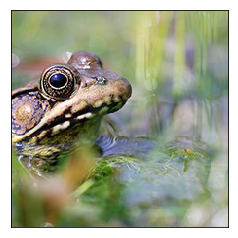


bullfrog: 0.99


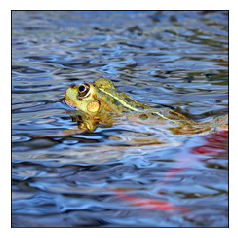

In [208]:
frogs = {'bullfrog', 'tree frog', 'tailed frog'}

for path, prediction in zip(image_paths_list, predictions):
    for photo_id,  animal, probability in prediction:
        
        if animal in frogs:
        
            print(f'{animal}: {probability:.2f}')

            plt.subplot()
            plt.imshow(np.asarray(Image.open(path)))
            plt.grid(False)
            plt.yticks([])
            plt.xticks([])
            plt.show()
            print()

## Part 3 - AutoML

Use [TPOT](https://github.com/EpistasisLab/tpot) to fit a predictive model for the King County housing data, with `price` as the target output variable.

As with previous questions, your goal is to run TPOT and successfully run and report error at the end.  Also, in the interest of time, feel free to choose small `generation=1` and `population_size=10` parameters so your pipeline runs efficiently and you are able to iterate and test.

*Hint* - you'll have to drop and/or type coerce at least a few variables to get things working. It's fine to err on the side of dropping to get things running, as long as you still get a valid model with reasonable predictive power.

In [5]:
import gc
gc.enable()

In [6]:
df_king = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/kc_house_data.csv')
df_king.shape

(21613, 21)

In [7]:
df_king = df_king[0:2999]

In [8]:
pipeline_optimizer = TPOTRegressor(generations=1, population_size=10,
                         offspring_size=None, mutation_rate=0.9,
                         crossover_rate=0.1,
                         scoring='neg_mean_squared_error', cv=2,
                         subsample=1.0, n_jobs=-1,
                         max_time_mins=None, max_eval_time_mins=5,
                         random_state=None, config_dict=None,
                         warm_start=False,
                         memory=None,
                         use_dask=False,
                         periodic_checkpoint_folder=None,
                         early_stop=None,
                         verbosity=2,
                         disable_update_check=False)

In [10]:
y = df_king['price']
X = df_king.drop(['price', 'id'], axis=1)

dummy_data = pd.get_dummies(data=X)
dummy_data = dummy_data.astype(np.float)

scaler = MinMaxScaler()
dummy_data = scaler.fit_transform(dummy_data)

# reduce the amount of data we have for time constraints
dummy_data = dummy_data
y = y


X_train, X_test, y_train, y_test = train_test_split(dummy_data, y, train_size=0.75, test_size=0.25)

In [11]:
pipeline_optimizer.fit(X_train, y_train)

Generation 1 - Current best internal CV score: -45684911858.15435

Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=9, min_child_weight=11, n_estimators=100, nthread=1, subsample=0.2)


TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=2,
       disable_update_check=False, early_stop=None, generations=1,
       max_eval_time_mins=5, max_time_mins=None, memory=None,
       mutation_rate=0.9, n_jobs=-1, offspring_size=None,
       periodic_checkpoint_folder=None, population_size=10,
       random_state=None, scoring='neg_mean_squared_error', subsample=1.0,
       use_dask=False, verbosity=2, warm_start=False)

In [12]:
pipeline_optimizer.export('tpot_price_pipeline.py')

In [13]:
print(pipeline_optimizer.score(X_test, y_test))

-23797638428.59157


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

preds = pipeline_optimizer.predict(X_test)
print('MAE for house price given 10 percent of the data:', mean_absolute_error(preds, y_test))

print('Explained variance:', explained_variance_score(preds, y_test))

MAE for house price given 10 percent of the data: 82315.01383333333
Explained variance: 0.7584791937992549


## Part 4 - More...

Answer the following questions, with a target audience of a fellow Data Scientist:

- What do you consider your strongest area, as a Data Scientist?

        I think my strongest area as a data scientist is definitely in natural language processing.
        I spent a good 50+ hours over the last month taking a deep dive into as many resources as I could find 
        to start building language models to classify 3D objects and to describe videos in real time with text.
        One that really made me stronger was a PhD class from Stanford that focused on replicating NLP's cutting edge research
        papers in Python. It is incredibly hard, and something I'm still working on. But I feel proud to say that I'm able to 
        do the work required at that level.
    
- What area of Data Science would you most like to learn more about, and why?

        I'm really interested in learning more about using data science for procedural generation and computer vision.
        I'd love to combine my NLP models with some sort of 3d object building algorithm to procedural generate 3d models. 
        I could see this being applied heavily to medicine, game development, and astronomy as there are lots of prototyping and 
        abstracted thinking across all three domains. 
- Where do you think Data Science will be in 5 years?
    
        I think there will be a very large emphasis on people who understand data structure and who are able to explore generated models.
        It's very likely we will continue to see more automation in model building, but from what I've seen these models are so good 
        at training on specific data that they often overfit. 
        It'll be up to humans to go in and shake things up enough to use these hyper-tuned models to generalize new data.

A few sentences per answer is fine - only elaborate if time allows.

Thank you for your hard work, and congratulations! You've learned a lot, and should proudly call yourself a Data Scientist.